In [1]:
%cd /content/drive/MyDrive/MultiLineLocalization
from LineLocal import PDist, VP, PDiff, combPV_concat, combPV_admm, combPV_tdoa_admm
from RadiusEst import WeightedAvg
from rotmap import hat, exp, log
from ToyData import ToyDataGenerator
from utils import Report
import numpy as np

import time
import pandas as pd
import scipy
from scipy.optimize import least_squares

/content/drive/MyDrive/MultiLineLocalization


In [3]:
noise = 1
gt = np.concatenate([np.random.uniform(0, np.pi/2, 3), np.array([np.random.randint(50, 100)]), np.array([np.random.randint(5, 10)])])
vert, pts, d, ls, pts_scans, pts_sprk= ToyDataGenerator(10, 5, 10, gt, 10, noise)

# Verification - Run Multiple Trails with Different Noise Levels

## Simply run each method with the inital guesses of all zeros
### The problem is that in some trails (~10%) the optimizations are diverged or converged to the local minima

In [4]:
num_trails = 30
noise = 0

data1 = Report.init_dict()
data2 = Report.init_dict()
data3 = Report.init_dict()
data4 = Report.init_dict()

for i in range(num_trails):
    gt = np.concatenate([np.random.uniform(0, np.pi/2, 3), np.array([np.random.randint(50, 100)]), np.array([np.random.randint(5, 10)])])
    vert, pts, d, ls, pts_scans, pts_sprk = ToyDataGenerator(10, 5, 10, gt, 10, noise)

    hypo1 = PDiff(pts, d).estimate_lsq()
    radius1 = WeightedAvg(pts, d, hypo1).estimate()
    hypo2 = VP(vert, ls).estimate_lsq()
    radius2 = WeightedAvg(pts, d, hypo2).estimate()
    hypo3 = PDist(pts, d, gt[4]).estimate_lsq()
    radius3 = WeightedAvg(pts, d, hypo3).estimate()
    hypo4 = combPV_admm(pts, d, vert, ls).admm()
    radius4 = WeightedAvg(pts, d, hypo4).estimate()

    data1 = Report.append_dict(hypo1, data1, i, radius1, gt, noise)
    data2 = Report.append_dict(hypo2, data2, i, radius2, gt, noise)
    data3 = Report.append_dict(hypo3, data3, i, radius3, gt, noise)
    data4 = Report.append_dict(hypo4, data4, i, radius4, gt, noise)

Report.OutExcel(data1, "results_PDiff_wo_init.xlsx")
Report.OutExcel(data2, "results_VP_wo_init.xlsx")
Report.OutExcel(data3, "results_PDist_wo_init.xlsx")
Report.OutExcel(data4, "results_admm_wo_init.xlsx")

## Run each method with multiple starting points (Grid Search)
### Almost all the trials are converged to global minima, method 4 is prone to be diverged

In [ ]:
num_trails = 30
noise = 0

data1 = Report.init_dict()
data2 = Report.init_dict()
data3 = Report.init_dict()
data4 = Report.init_dict()

for i in range(num_trails):
    gt = np.concatenate([np.random.uniform(0, np.pi/2, 3), np.array([np.random.randint(50, 100)]), np.array([np.random.randint(5, 10)])])

    hypo1_lst, hypo2_lst, hypo3_lst, hypo4_lst = [], [], [], []
    rad1_lst, rad2_lst, rad3_lst, rad4_lst = [], [], [], []
    best1, best2, best3, best4 = 1e5, 1e5, 1e5, 1e5

    vert, pts, d, ls, pts_scans, pts_sprk = ToyDataGenerator(10, 5, 10, gt, 10, noise)

    # grid search
    x_init = [np.zeros(4,), np.ones(4,)* 1/2, np.ones(4,),
              np.array([1/2, 0, 0, 0]), np.array([0, 1/2, 0, 0]), np.array([0, 0, 1/2, 0]),
              np.array([1/2, 1/2, 0, 0]), np.array([0, 1/2, 1/2, 0]), np.array([1/2, 0, 1/2, 0]),
              np.array([0, 1, 0, 0]), np.array([1, 0, 0, 0]), np.array([0, 0, 1, 0]),
              np.array([1, 1, 0, 0]), np.array([1, 0, 1, 0]), np.array([0, 1, 1, 0]),]

    for j in range(len(x_init)):
        hypo1_lst.append(PDiff(pts, d).estimate_lsq(x0 =x_init[j]))
        rad1_lst.append(WeightedAvg(pts, d, hypo1_lst[-1]).estimate())
        hypo2_lst.append(VP(vert, ls).estimate_lsq(x0 =x_init[j]))
        rad2_lst.append(WeightedAvg(pts, d, hypo2_lst[-1]).estimate())
        hypo3_lst.append(PDist(pts, d, gt[4]).estimate_lsq(x0 =x_init[j]))
        rad3_lst.append(WeightedAvg(pts, d, hypo3_lst[-1]).estimate())
        hypo4_lst.append(combPV_admm(pts, d, vert, ls).admm(x0 =x_init[j], v0 = x_init[j]))
        rad4_lst.append(WeightedAvg(pts, d, hypo4_lst[-1]).estimate())

        if PDiff(pts, d).loss(x = hypo1_lst[j][:4]) < best1:
            best1 = PDiff(pts, d).loss(x = hypo1_lst[j][:4])
            best_idx1 = j
            hypo1 = hypo1_lst[j]
            radius1 = rad1_lst[j]

        if VP(vert, ls).loss(x = hypo2_lst[j][:4]) < best2:
            best2 = VP(vert, ls).loss(x = hypo2_lst[j][:4])
            best_idx2 = j
            hypo2 = hypo2_lst[j]
            radius2 = rad2_lst[j]

        if PDist(pts, d, gt[4]).loss(x = hypo3_lst[j][:4], r = gt[4]) < best3:
            best3 = PDist(pts, d, gt[4]).loss(x = hypo3_lst[j][:4], r = gt[4])
            best_idx3 = j
            hypo3 = hypo3_lst[j]
            radius3 = rad3_lst[j]

        if combPV_admm(pts, d, vert, ls).loss(x = hypo4_lst[j][:4]) < best4:
            best4 = combPV_admm(pts, d, vert, ls).loss(x = hypo4_lst[j][:4])
            best_idx4 = j
            hypo4 = hypo4_lst[j]
            radius4 = rad4_lst[j]

    data1 = Report.append_dict(hypo1, data1, i, radius1, gt, noise)
    data2 = Report.append_dict(hypo2, data2, i, radius2, gt, noise)
    data3 = Report.append_dict(hypo3, data3, i, radius3, gt, noise)
    data4 = Report.append_dict(hypo4, data4, i, radius4, gt, noise)

Report.OutExcel(data1, "results_PDiff_grid_search.xlsx")
Report.OutExcel(data2, "results_VP_grid_search.xlsx")
Report.OutExcel(data3, "results_PDist_grid_search.xlsx")
Report.OutExcel(data4, "results_admm_grid_search.xlsx")

## Run each methods and compare the results, choose the best one as the inital guess

In [ ]:
num_trails = 30
noise = 0

data1 = Report.init_dict()
data2 = Report.init_dict()
data3 = Report.init_dict()
data4 = Report.init_dict()

for i in range(num_trails):
    gt = np.concatenate([np.random.uniform(0, np.pi/2, 3), np.array([np.random.randint(50, 100)]), np.array([np.random.randint(5, 10)])])

    vert, pts, d, ls, pts_scans, pts_sprk = ToyDataGenerator(10, 5, 10, gt, 10, noise)

    hypo1 = PDiff(pts, d).estimate_lsq()
    radius1 = WeightedAvg(pts, d, hypo1).estimate()
    hypo2 = VP(vert, ls).estimate_lsq()
    radius2 = WeightedAvg(pts, d, hypo2).estimate()
    hypo3 = PDist(pts, d, gt[4]).estimate_lsq()
    radius3 = WeightedAvg(pts, d, hypo3).estimate()
    hypo4 = combPV_admm(pts, d, vert, ls).admm()
    radius4 = WeightedAvg(pts, d, hypo4).estimate()

    hypos = [hypo1, hypo2, hypo3, hypo4]

    for j in hypos:
        if PDiff(pts, d).loss(j) < PDiff(pts, d).loss(hypo1):
            hypo1 =  PDiff(pts, d).estimate_lsq(x0 = j)
            radius1 = WeightedAvg(pts, d, hypo1).estimate()
        if VP(vert, ls).loss(j) < VP(vert, ls).loss(hypo2):
            hypo2 = VP(vert, ls).estimate_lsq(x0 = j)
            radius2 = WeightedAvg(pts, d, hypo2).estimate()
        if PDist(pts, d, gt[4]).loss(j, gt[4]) < PDist(pts, d, gt[4]).loss(hypo3, gt[4]):
            hypo3 = PDist(pts, d, gt[4]).estimate_lsq(x0 = j)
            radius3 = WeightedAvg(pts, d, hypo3).estimate()
        if combPV_admm(pts, d, vert, ls).loss(j) < combPV_admm(pts, d, vert, ls).loss(hypo4):
            hypo4 = combPV_admm(pts, d, vert, ls).admm(a = 0.1, x0 = j, v0 = j)
            radius4 = WeightedAvg(pts, d, hypo4).estimate()

    data1 = Report.append_dict(hypo1, data1, i, radius1, gt, noise)
    data2 = Report.append_dict(hypo2, data2, i, radius2, gt, noise)
    data3 = Report.append_dict(hypo3, data3, i, radius3, gt, noise)
    data4 = Report.append_dict(hypo4, data4, i, radius4, gt, noise)

Report.OutExcel(data1, "results_PDiff_compare.xlsx")
Report.OutExcel(data2, "results_VP_compare.xlsx")
Report.OutExcel(data3, "results_PDist_compare.xlsx")
Report.OutExcel(data4, "results_admm_compare.xlsx")



# Validation - Simulated Data

In [ ]:
%cd /content/drive/MyDrive/MultiLineLocalization
from LineLocal import PDiff_tdoa
import pickle
import numpy as np

/content/drive/MyDrive/MultiLineLocalization


In [ ]:
with open('ddoa.pkl', 'rb') as f:
    ddoa = pickle.load(f)
with open('pts.pkl', 'rb') as f:
    pts = pickle.load(f)

In [ ]:
pts_mat = dict()
for k in range(pts.shape[0]):
    for i in range(pts.shape[1]):
        for j in range(pts.shape[1]):
            pts_mat[k+1, i, j] = [pts[k,i,:], pts[k,j,:]]

In [ ]:
pt1 = []
pt2 = []
d = []
for k in range(0, 5):
    for i in range(30):
        for j in range(i):
            pt1.append(pts_mat[k+1, i, j][0])
            pt2.append(pts_mat[k+1, i, j][1])
            d.append(ddoa[k+1][i, j])

In [ ]:
pt1 = np.array(pt1).reshape(-1,3)
pt2 = np.array(pt2).reshape(-1,3)
d = np.array(d)/2

In [ ]:
d.shape

(2175,)

In [ ]:
hypo = PDiff_tdoa(pt1, pt2, d).estimate_lsq()
print(hypo)

[ 0.04545903 -1.56986053  0.04557427 -0.12016295]


In [ ]:
PDiff_tdoa(pt1, pt2, d).loss(hypo)

2.8429808386287872e-08

In [ ]:
R = exp(np.array(hypo[:3]).reshape(1,3,1))
R[0,:,0]

array([4.54073881e-04, 8.65532497e-05, 9.99999893e-01])

In [ ]:
np.rad2deg(np.arccos(np.dot(R[0,:,0].reshape(-1), np.array([0,0,1]))))

0.026484943533941967

In [ ]:
with open('ls.pkl', 'rb') as f:
    ls = pickle.load(f)
with open('vert.pkl', 'rb') as f:
    vert = pickle.load(f)

In [ ]:
pt_vert = dict()
for i in range(0, 5):
    bottom = int(np.floor(vert[i+1]))
    if bottom == 29:
        pt_vert[i] = pts[i][bottom, :]
    else:
        pt_vert[i] = (vert[i+1] - bottom)*(pts[i][bottom+1, :] - pts[i][bottom, :]) + pts[i][bottom, :]

In [ ]:
ls_mat = []
pt_vert_mat = []
for i in range(0, 5):
    ls_mat.append(ls[i+1])
    pt_vert_mat.append(pt_vert[i])
ls_mat = np.array(ls_mat).reshape(-1, 3, 1)
pt_vert_mat = np.array(pt_vert_mat)
hypo = VP(pt_vert_mat, ls_mat).estimate_lsq(x0 = hypo)
R = exp(np.array(hypo[:3]).reshape(1,3,1))
np.rad2deg(np.arccos(np.dot(R[0,:,0].reshape(-1), np.array([0,0,1])))), hypo


(0.007866576934093622,
 array([ 0.01648598, -1.57069564,  0.01627901, -0.1200182 ]))

In [ ]:
hypo =combPV_tdoa_admm(pt1, pt2, d, pt_vert_mat, ls_mat).admm(x0 = hypo)
combPV_tdoa_admm(pt1, pt2, d, pt_vert_mat, ls_mat).loss(hypo)
hypo

array([ 0.08102528, -0.63931039,  0.0052003 ,  0.05805323])

In [ ]:
R = exp(np.array(hypo[:3]).reshape(1,3,1))
np.rad2deg(np.arccos(np.dot(R[0,:,0].reshape(-1), np.array([1,0,0])))), R[0,:,0]

(36.62055249816001, array([ 0.80260355, -0.02016834,  0.59617177]))

In [ ]:
vert, pts, d, ls, pts_scans, pts_sprk = ToyDataGenerator(10, 5, 10, gt, 10, noise)

In [ ]:
# hypo1 = localPD(pt, d, 5).estimate_lsq()
hypo1 = PDiff(pts, d).estimate_lsq(x0 = np.array([1,0,1,0]))
radius1 = WeightedAvg(pts, d, hypo1).estimate()
hypo2 = VP(vert, ls).estimate_lsq()
# distances = VP(vert, ls).residuals(hypo1)
radius2 = WeightedAvg(pts, d, hypo2).estimate()
hypo3 = PDist(pts, d, 5).estimate_lsq()
radius3 = WeightedAvg(pts, d, hypo3).estimate()
hypo4 = combPV_admm(pts, d, vert, ls).admm()
radius4 = WeightedAvg(pts, d, hypo4).estimate()

In [ ]:
hypo1, hypo2, hypo3, hypo4, gt

(array([  -1.22004044, -100.95520463,  -72.41585423,   70.58586056]),
 array([2.37471001e-02, 1.13393622e+00, 8.34935982e-01, 7.03135405e+01]),
 array([1.33222646e-02, 1.14374807e+00, 8.25117188e-01, 6.96506597e+01]),
 array([1.59837600e-02, 1.15841591e+00, 8.34839106e-01, 7.06957983e+01]),
 array([5.58842624e-03, 1.13760752e+00, 8.30833236e-01, 7.10000000e+01,
        6.00000000e+00]))

In [ ]:
rot = np.array(gt[:3])
loss = []
for i in range(100):
    rho = i
    loss.append(VP(vert, ls).loss(np.concatenate([rot, np.array(rho).reshape(-1)])))
# PDist(pts, d, 5).residuals(hypo3, 5)

In [ ]:
theta1 = RA(hypo1, gt)
theta2 = RA(hypo2, gt)
theta3 = RA(hypo3, gt)
theta4 = RA(hypo4, gt)

sd1 = SD(hypo1, gt)
sd2 = SD(hypo2, gt)
sd3 = SD(hypo3, gt)
sd4 = SD(hypo4, gt)


rr1 = RR(radius1, gt[4])
rr2 = RR(radius2, gt[4])
rr3 = RR(radius3, gt[4])
rr4 = RR(radius4, gt[4])
theta1, theta2, theta3, theta4, sd1, sd2, sd3, sd4, rr1, rr2, rr3, rr4

(array([[0.00799133]]),
 array([[0.01465769]]),
 array([[0.0019751]]),
 array([[0.01917839]]),
 0.9794517477281852,
 0.12960003170005713,
 0.72112123717258,
 0.9062671797985021,
 0.0005626178825253921,
 0.08334637037670307,
 0.0967857120944416,
 0.009399513662836867)

In [ ]:
s = pd.Series(data, index=pd.MultiIndex.from_tuples(data))
df = s.unstack()
df.columns = ["noise", "gt",
            "hypo1", "hypo2", "hypo3", "hypo4",
            "rad1", "rad2", "rad3", "rad4",
            "RA1", "RA2", "RA3", "RA4",
            "SD1", "SD2", "SD3", "SD4",
            "RR1", "RR2", "RR3", "RR4"]
df.to_excel('results.xlsx')

In [ ]:
# Start measuring time
start_time = time.time()

# Your code block or function goes here
hypo4 = combPV_admm(pts, d, vert, ls).admm()
radius4 = WeightedAvg(pts, d, hypo4).estimate()

# End measuring time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time:.2f} seconds")


[ 0.30283489 -0.20153112  0.09923194 49.97311286]
Elapsed time: 5.89 seconds


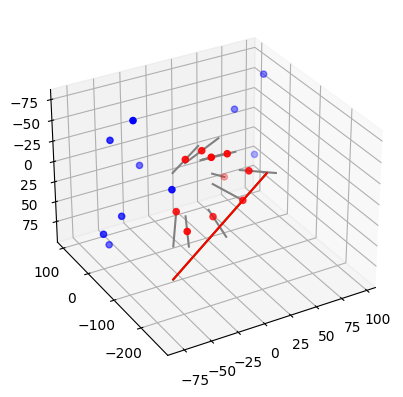

In [ ]:
import matplotlib.pyplot as plt
from rotmap import hat
"""
measurement points
"""
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.invert_zaxis()
# ax.scatter(pt1[:,0], pt1[:,1], pt1[:,2])
# ax.scatter(pt2[:,0], pt2[:,1], pt2[:,2])
ax.scatter(pts_sprk[:,0], pts_sprk[:,1], pts_sprk[:,2], c = "blue")
ax.scatter(vert[:,0], vert[:,1], vert[:,2], c = "red")
"""
3d lines
"""
R_gt = exp(gt[:3].reshape(1, 3, 1))
l_gt = R_gt[:,:,0]
m_gt = gt[3] * R_gt[:,:,1]
p0 = (- np.linalg.pinv(hat(l_gt.reshape(1,3,1))) @ m_gt.reshape(3,1)).reshape(-1)

# Plot gt line
xline = np.linspace(np.min(pts[:,0]), np.max(pts[:,0]), 1000)
yline = (xline - p0[0]) * l_gt[0, 1] / l_gt[0, 0] + p0[1]
zline = (xline - p0[0]) * l_gt[0, 2] / l_gt[0, 0] + p0[2]
ax.plot3D(xline, yline, zline, 'green')

# Plot line scans
num_pts_per_line = 5
for i in range(10):
    xline = pts_scans[(num_pts_per_line*i):(num_pts_per_line*i+num_pts_per_line),0].reshape(-1)
    yline = pts_scans[(num_pts_per_line*i):(num_pts_per_line*i+num_pts_per_line),1].reshape(-1)
    zline = pts_scans[(num_pts_per_line*i):(num_pts_per_line*i+num_pts_per_line),2].reshape(-1)
    ax.plot3D(xline, yline, zline, 'gray')

R_est = exp(hypo2[:3].reshape(1, 3, 1))
l_est = R_est[:,:,0]
m_est = hypo2[3] * R_est[:,:,1]
p0 = (- np.linalg.pinv(hat(l_est.reshape(1,3,1))) @ m_est.reshape(3,1)).reshape(-1)
# Plot estimated line
xline_est = np.linspace(np.min(pts[:,0]), np.max(pts[:,0]), 1000)
yline_est = (xline_est - p0[0]) * l_est[0, 1] / l_est[0, 0] + p0[1]
zline_est = (xline_est - p0[0]) * l_est[0, 2] / l_est[0, 0] + p0[2]
ax.plot3D(xline_est, yline_est, zline_est, 'red')

ax.view_init(elev=30, azim=-120)

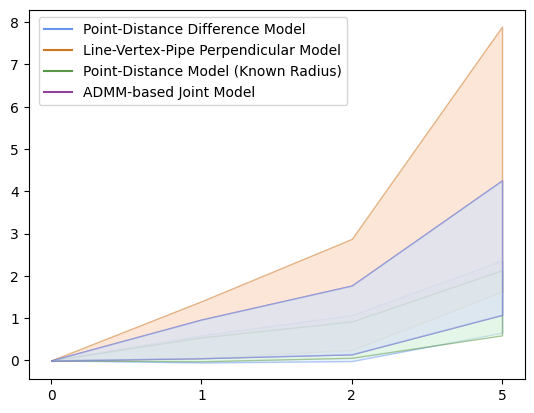

In [ ]:
RA = pd.read_excel('Compiled_toydata.xlsx', sheet_name="RA", header = None)
SD = pd.read_excel('Compiled_toydata.xlsx', sheet_name="SD", header = None)
RR = pd.read_excel('Compiled_toydata.xlsx', sheet_name="RR", header = None)

fig = plt.figure()
ax = fig.add_subplot(111)
labels = [0, 1, 2, 5]


x = np.linspace(0, 3, 4)
y = np.rad2deg(np.array([RA.loc[0,0], RA.loc[0,2], RA.loc[0,4], RA.loc[0,6]]))
error = np.rad2deg(np.array([RA.loc[0,1], RA.loc[0,3], RA.loc[0,5], RA.loc[0,7]]))

method1, = ax.plot(x, y, 'k', color=(100/255, 149/255, 237/255), label='Point-Distance Difference Model')
plt.fill_between(x, y-error, y+error,
    alpha=0.5, edgecolor=(100/255, 149/255, 237/255), facecolor=(214/255, 234/255, 248/255))


x = np.linspace(0, 3, 4)
y = np.rad2deg(np.array([RA.loc[1,0], RA.loc[1,2], RA.loc[1,4], RA.loc[1,6]]))
error = np.rad2deg(np.array([RA.loc[1,1], RA.loc[1,3], RA.loc[1,5], RA.loc[1,7]]))

method2, = ax.plot(x, y, 'k', color=(204/255, 119/255, 34/255), label='Line-Vertex-Pipe Perpendicular Model')
plt.fill_between(x, y-error, y+error,
    alpha=0.5, edgecolor=(204/255, 119/255, 34/255), facecolor=(251/255, 206/255, 177/255))

x = np.linspace(0, 3, 4)
y = np.rad2deg(np.array([RA.loc[2,0], RA.loc[2,2], RA.loc[2,4], RA.loc[2,6]]))
error = np.rad2deg(np.array([RA.loc[2,1], RA.loc[2,3], RA.loc[2,5], RA.loc[2,7]]))

method3, = ax.plot(x, y, 'k', color=(90/255, 151/255, 68/255), label='Point-Distance Model (Known Radius)')
plt.fill_between(x, y-error, y+error,
    alpha=0.5, edgecolor=(90/255, 151/255, 68/255), facecolor=(223/255, 248/255, 214/255))

x = np.linspace(0, 3, 4)
y = np.rad2deg(np.array([RA.loc[3,0], RA.loc[3,2], RA.loc[3,4], RA.loc[3,6]]))
error = np.rad2deg(np.array([RA.loc[3,1], RA.loc[3,3], RA.loc[3,5], RA.loc[3,7]]))

method4, = ax.plot(x, y, 'k', color=(141/255, 68/255, 151/255), label='ADMM-based Joint Model')
plt.fill_between(x, y-error, y+error,
    alpha=0.5, edgecolor=(141/255, 68/255, 151/255), facecolor=(228/255, 213/255, 230/255))
ax.set_xticks(range(4))
ax.set_xticklabels(labels)
ax.legend(handles=[method1, method2, method3, method4], bbox_to_anchor=(0.02, 0.98),
                         loc='upper left', borderaxespad=0.)
plt.show()

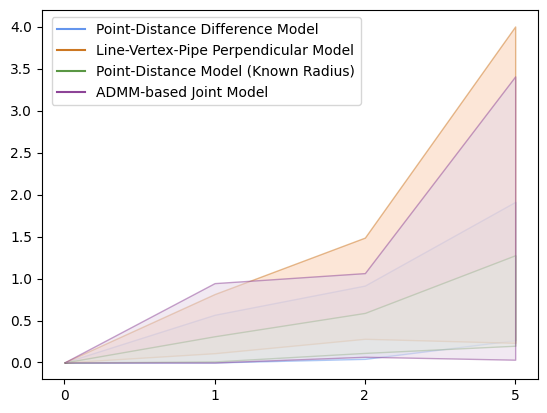

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(111)
labels = [0, 1, 2, 5]

x = np.linspace(0, 3, 4)
y = np.array([SD.loc[0,0], SD.loc[0,2], SD.loc[0,4], SD.loc[0,6]])
error = np.array([SD.loc[0,1], SD.loc[0,3], SD.loc[0,5], SD.loc[0,7]])
yminus = y-error
yminus[yminus<0] = 0
# method1, = ax.plot(x, y, 'k', color=(100/255, 149/255, 237/255), label='Point-Distance Difference Model')
plt.fill_between(x, yminus, y+error,
    alpha=0.5, edgecolor=(100/255, 149/255, 237/255), facecolor=(214/255, 234/255, 248/255))


x = np.linspace(0, 3, 4)
y = np.array([SD.loc[1,0], SD.loc[1,2], SD.loc[1,4], SD.loc[1,6]])
error = np.array([SD.loc[1,1], SD.loc[1,3], SD.loc[1,5], SD.loc[1,7]])
yminus = y-error
yminus[yminus<0] = 0
# method2, = ax.plot(x, y, 'k', color=(204/255, 119/255, 34/255), label='Line-Vertex-Pipe Perpendicular Model')
plt.fill_between(x, yminus, y+error,
    alpha=0.5, edgecolor=(204/255, 119/255, 34/255), facecolor=(251/255, 206/255, 177/255))

x = np.linspace(0, 3, 4)
y = np.array([SD.loc[2,0], SD.loc[2,2], SD.loc[2,4], SD.loc[2,6]])
error = np.array([SD.loc[2,1], SD.loc[2,3], SD.loc[2,5], SD.loc[2,7]])
yminus = y-error
yminus[yminus<0] = 0
# method3, = ax.plot(x, y, 'k', color=(90/255, 151/255, 68/255), label='Point-Distance Model (Known Radius)')
plt.fill_between(x, yminus, y+error,
    alpha=0.5, edgecolor=(90/255, 151/255, 68/255), facecolor=(223/255, 248/255, 214/255))

x = np.linspace(0, 3, 4)
y = np.array([SD.loc[3,0], SD.loc[3,2], SD.loc[3,4], SD.loc[3,6]])
error = np.array([SD.loc[3,1], SD.loc[3,3], SD.loc[3,5], SD.loc[3,7]])
yminus = y-error
yminus[yminus<0] = 0
# method4, = ax.plot(x, y, 'k', color=(141/255, 68/255, 151/255), label='ADMM-based Joint Model')
plt.fill_between(x, yminus, y+error,
    alpha=0.5, edgecolor=(141/255, 68/255, 151/255), facecolor=(228/255, 213/255, 230/255))
ax.set_xticks(range(4))
ax.set_xticklabels(labels)

ax.legend(handles=[method1, method2, method3, method4], bbox_to_anchor=(0.02, 0.98),
                         loc='upper left', borderaxespad=0.)
plt.show()

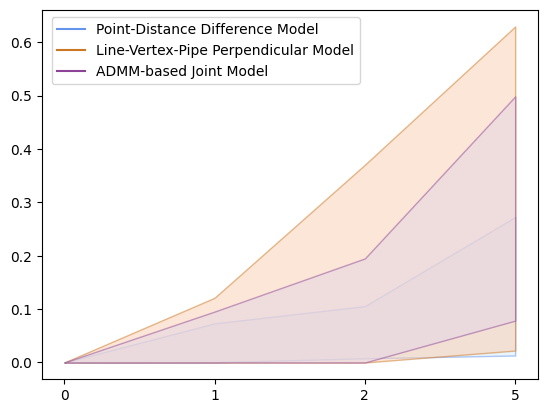

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
labels = [0, 1, 2, 5]

x = np.linspace(0, 3, 4)
y = np.array([RR.loc[0,0], RR.loc[0,2], RR.loc[0,4], RR.loc[0,6]])
error = np.array([RR.loc[0,1], RR.loc[0,3], RR.loc[0,5], RR.loc[0,7]])
yminus = y-error
yminus[yminus<0] = 0
# method1, = ax.plot(x, y, 'k', color=(100/255, 149/255, 237/255), label='Point-Distance Difference Model')
plt.fill_between(x, yminus, y+error,
    alpha=0.5, edgecolor=(100/255, 149/255, 237/255), facecolor=(214/255, 234/255, 248/255))


x = np.linspace(0, 3, 4)
y = np.array([RR.loc[1,0], RR.loc[1,2], RR.loc[1,4], RR.loc[1,6]])
error = np.array([RR.loc[1,1], RR.loc[1,3], RR.loc[1,5], RR.loc[1,7]])
yminus = y-error
yminus[yminus<0] = 0
# method2, = ax.plot(x, y, 'k', color=(204/255, 119/255, 34/255), label='Line-Vertex-Pipe Perpendicular Model')
plt.fill_between(x, yminus, y+error,
    alpha=0.5, edgecolor=(204/255, 119/255, 34/255), facecolor=(251/255, 206/255, 177/255))

x = np.linspace(0, 3, 4)
y = np.array([RR.loc[3,0], RR.loc[3,2], RR.loc[3,4], RR.loc[3,6]])
error = np.array([RR.loc[3,1], RR.loc[3,3], RR.loc[3,5], RR.loc[3,7]])
yminus = y-error
yminus[yminus<0] = 0
# method4, = ax.plot(x, y, 'k', color=(141/255, 68/255, 151/255), label='ADMM-based Joint Model')
plt.fill_between(x, yminus, y+error,
    alpha=0.5, edgecolor=(141/255, 68/255, 151/255), facecolor=(228/255, 213/255, 230/255))
ax.set_xticks(range(4))
ax.set_xticklabels(labels)

ax.legend(handles=[method1, method2, method4], bbox_to_anchor=(0.02, 0.98),
                         loc='upper left', borderaxespad=0.)
plt.show()

In [ ]:
ax3.xaxis.set_major_locator(mticker.MaxNLocator(3))
ticks_loc = ax3.get_xticks().tolist()

In [ ]:
np.random.seed(1001)
n = 100  # number of points

pt1 = np.random.randn(n, 3, 1)
pt2 = np.random.randn(n, 3, 1) + 1
rho1_gt = 50
rho2_gt = 100
r_gt = 5
v1 = np.array([0.3, -0.2, 0.1]).reshape(3, 1)
v2 = np.array([0, 0, 0]).reshape(3, 1)
R1_gt = exp(v1)
R2_gt = exp(v2)
b1 = np.array([1, 0, 0]).reshape(3,1)
B1 = hat(b1)
b2 = np.array([0,1,0]).reshape(3,1)
pt1_rot = R1_gt.T @ pt1
d1_vec = -B1 @ pt1_rot-rho1_gt*b2
pt2_rot = R2_gt.T @ pt2
d2_vec = -B1 @ pt2_rot-rho2_gt*b2
d1 = np.linalg.norm(d1_vec, axis=(1,2)) - r_gt
d2 = np.linalg.norm(d2_vec, axis=(1,2)) - r_gt

In [ ]:
import scipy
pts = np.vstack([pt1, pt2, pt]).reshape(-1, 3)
ds = np.concatenate([d1, d2, d])
# ind_del = np.random.choice(n * 2, 100, False)
# cls = t_linkage(pts, ds, LineLocal, 100)
# pts = np.delete(pts, ind_del, axis = 0)
# ds = np.delete(ds, ind_del, axis = 0)
cls, PF_init, PF = t_linkage(pts, ds, LineLocal, 100)

NameError: ignored

In [ ]:
import itertools
np.random.seed(1001)
n = 100  # number of points
b1 = np.array([1, 0, 0]).reshape(3,1)
b2 = np.array([0, 1, 0]).reshape(3,1)
b3 = np.array([0, 0, 1]).reshape(3,1)
v_s = np.random.randn(n, 3, 1)
rho_s = np.random.randn(n, 1) * 10
R_s = exp(v_s)
ls = R_s @ b1
ms = np.multiply(rho_s[:, np.newaxis], R_s) @ b2
rho_gt = 50
r_gt = 5
v = np.array([0.3, -0.2, 0.1]).reshape(3, 1)
R_gt = exp(v)
l_gt = R_gt @ b1
m_gt = rho_gt * R_gt @ b2
l_gt_stack = np.tile(l_gt, (n, 1, 1))
m_gt_stack = np.tile(m_gt, (n, 1, 1))
numerator1 = -np.cross(ms, np.cross(l_gt_stack, np.cross(ls, l_gt_stack, axis = 1), axis = 1), axis = 1)
numerator2 = (m_gt_stack.swapaxes(1,2) @ np.cross(ls, l_gt_stack, axis = 1)).swapaxes(1,2) * ls
denominator = np.linalg.norm(np.cross(l_gt_stack, ls, axis = 1), axis = (1,2)) ** 2
vert = ((numerator1 + numerator2).reshape(-1,3)/denominator.reshape(-1,1)).reshape(-1,3,1) + np.random.randn(n, 3, 1)
pt = vert + np.random.randn(n, 3, 1) * 100
pt_rot = R1_gt.T @ pt
d_vec = -B1 @ pt_rot-rho_gt*b2
d = np.linalg.norm(d_vec, axis=(1,2)) - r_gt + np.random.randn(pt.shape[0])

In [ ]:
def t_linkage(pts, d, model, num_hypo, num_samples = 30, sigma = 0.1, cs_thresh = 2, verbose = False):

    initial_preference_matrix = build_preference_matrix_tlinkage(pts, d, model,num_hypo, num_samples, sigma, cs_thresh)
    preference_matrix, clusters = tlinkage_clustering(initial_preference_matrix)

    # if verbose == True:
    #     for i in range(len(clusters)):
    #         plt.plot(pts[clusters[i]][:,0],pts[clusters[i]][:,1],'.')

    return clusters, initial_preference_matrix, preference_matrix


def sample_pts(pts, d, sigma, num_samples):

    num_pts = pts.shape[0]
    dist_matrix = scipy.spatial.distance.cdist(pts.reshape(-1,3), pts.reshape(-1,3))
    prob_matrix = np.exp(-dist_matrix**2 /sigma**2)
    np.fill_diagonal(prob_matrix,0)

    pt_lst, d_lst = [], []

    for i in range(num_samples):
        if i == 0:
            sampled_index = np.random.choice(num_pts, 1, False)
        else:
            sampled_index = np.random.choice(num_pts, 1, p = prob_select_next)
        pt_select = pts[sampled_index]
        d_select = d[sampled_index]
        prob_matrix[:,sampled_index] = 0
        prob_select_next = (prob_matrix[sampled_index,:]/np.sum(prob_matrix[sampled_index,:])).squeeze()
        pt_lst.append(pt_select)
        d_lst.append(d_select)

    return np.array(pt_lst).reshape(num_samples,3,1), np.array(d_lst).reshape(num_samples)

# def sample_pts(pts, d, num_samples):

#     num_pts =pts.shape[0]
#     sampled_index = np.random.choice(num_pts, num_samples, False)

#     return pts[sampled_index,:,:], d[sampled_index]


def build_preference_matrix_tlinkage(pts, d, model, num_hypotheses, num_samples, sigma, consensus_threshold):

    num_pts = pts.shape[0]

    preference_mat = np.zeros((num_pts, num_hypotheses)).astype(float)

    for i_hypo in range(num_hypotheses):
        pts_samples, d_samples = sample_pts(pts, d, sigma, num_samples)
        hypo = model(pts_samples, d_samples).estimate()
        distances = model(pts, d).loss(hypo, 5)

        for i_pt in range(num_pts):
            distance = distances[i_pt]
            preference_mat[i_pt, i_hypo] = np.exp(-distance/consensus_threshold) if distance < 5*consensus_threshold else 0

    return preference_mat

def tlinkage_clustering(preference_mat):

    keep_clustering = True
    cluster_step = 0

    num_clusters = preference_mat.shape[0]
    clusters = [[i] for i in range(num_clusters)]

    while keep_clustering:
        smallest_distance = 1
        best_combo = None
        keep_clustering = False

        preference_mat = np.matrix(preference_mat)
        preference_mat_selfprod = preference_mat * preference_mat.T
        num_clusters = preference_mat.shape[0]

        for i in range(num_clusters):
            for j in range(i):
                distance = 1 - preference_mat_selfprod[i,j] / \
                           np.maximum((preference_mat_selfprod[i,i] +
                                       preference_mat_selfprod[j,j] -
                                       preference_mat_selfprod[i,j]), 1e-8)

                if distance < smallest_distance:
                    keep_clustering = True
                    smallest_distance = distance
                    best_combo = (i,j)

        if keep_clustering:
            clusters[best_combo[0]] += clusters[best_combo[1]]
            clusters.pop(best_combo[1])
            set_a = preference_mat[best_combo[0]]
            set_b = preference_mat[best_combo[1]]
            merged_set = np.minimum(set_a, set_b)
            preference_mat[best_combo[0]] = merged_set
            preference_mat = np.delete(preference_mat, best_combo[1], axis=0)
            cluster_step += 1

    print("clustering finished after %d steps" % cluster_step)

    return preference_mat, clusters